In [35]:
# First we will get channel data from linkin park audio using pydub
# then find fft using matplotlib.mlab as well as numpy and compare the two
from pydub import AudioSegment
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import hashlib
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from termcolor import colored
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import (generate_binary_structure, iterate_structure, binary_erosion)
from operator import itemgetter
IDX_FREQ_I = 0
IDX_TIME_J = 1

# Sampling rate, related to the Nyquist conditions, which affects
# the range frequencies we can detect.
DEFAULT_FS = 44100

# Size of the FFT window, affects frequency granularity
DEFAULT_WINDOW_SIZE = 4096 #2048 in SHAZOOM

# Ratio by which each sequential window overlaps the last and the
# next window. Higher overlap will allow a higher granularity of offset
# matching, but potentially more fingerprints.
DEFAULT_OVERLAP_RATIO = 0.5

# Degree to which a fingerprint can be paired with its neighbors --
# higher will cause more fingerprints, but potentially better accuracy.
DEFAULT_FAN_VALUE = 15

# Minimum amplitude in spectrogram in order to be considered a peak.
# This can be raised to reduce number of fingerprints, but can negatively
# affect accuracy.
DEFAULT_AMP_MIN = 10

# Number of cells around an amplitude peak in the spectrogram in order
# for Dejavu to consider it a spectral peak. Higher values mean less
# fingerprints and faster matching, but can potentially affect accuracy.
PEAK_NEIGHBORHOOD_SIZE = 20

# Thresholds on how close or far fingerprints can be in time in order
# to be paired as a fingerprint. If your max is too low, higher values of
# DEFAULT_FAN_VALUE may not perform as expected.
MIN_HASH_TIME_DELTA = 0
MAX_HASH_TIME_DELTA = 200

# If True, will sort peaks temporally for fingerprinting;
# not sorting will cut down number of fingerprints, but potentially
# affect performance.
PEAK_SORT = True

# Number of bits to throw away from the front of the SHA1 hash in the
# fingerprint calculation. The more you throw away, the less storage, but
# potentially higher collisions and misclassifications when identifying songs.
FINGERPRINT_REDUCTION = 20


In [71]:
audiofile = AudioSegment.from_file("mp3/Ilahi.mp3")
data = np.fromstring(audiofile._data, np.int16)
channels = []
for chn in range(audiofile.channels):
    channels.append(data[chn::audiofile.channels])

print(len(channels[0]),len(data))

10213140 20426280


/tmp/ipykernel_31302/1609569509.py:2: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(audiofile._data, np.int16)


In [100]:
Fs = 44100 # sampling freq
arr2D, myf, myt = mlab.specgram(
    channels[0],
    NFFT=2048,
    Fs=Fs,
    window=mlab.window_hanning,
    noverlap=1024)


9972


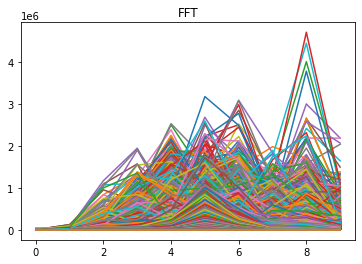

/home/shikhar/Desktop/Projects/Whats That Song/venv/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


(array([[1.12650202e-04, 2.19853357e-04, 1.00975129e-03, ...,
         8.97358660e-07, 7.72667828e-08, 0.00000000e+00],
        [1.34872353e-02, 2.48869130e-02, 2.10279063e-02, ...,
         9.06447962e-06, 1.54533202e-07, 0.00000000e+00],
        [6.35038497e-02, 9.95615978e-02, 8.99815653e-02, ...,
         5.18318762e-06, 1.54532111e-07, 0.00000000e+00],
        ...,
        [2.79679432e-06, 8.36837449e-07, 3.77663265e-06, ...,
         6.74510149e-08, 1.54065474e-12, 0.00000000e+00],
        [5.94338022e-06, 6.76303196e-07, 6.27971269e-07, ...,
         4.99206721e-08, 4.49762194e-13, 0.00000000e+00],
        [7.03978989e-06, 5.76957569e-09, 6.07345607e-07, ...,
         5.02337072e-09, 4.30651016e-14, 0.00000000e+00]]),
 array([0.00000000e+00, 2.15332031e+01, 4.30664062e+01, ...,
        2.20069336e+04, 2.20284668e+04, 2.20500000e+04]),
 array([2.32199546e-02, 6.67573696e-02, 1.10294785e-01, ...,
        2.31468118e+02, 2.31511655e+02, 2.31555193e+02]),
 <matplotlib.image.AxesImag

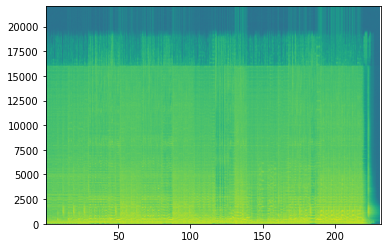

In [73]:
print(len(arr2D[0]))
plt.plot(arr2D[:10])
plt.title('FFT')
plt.show()
plt.specgram(channels[0],2048,44100)

In [36]:
def get_2D_peaks(arr2D, plot=False, amp_min=DEFAULT_AMP_MIN):
    # http://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.morphology.iterate_structure.html#scipy.ndimage.morphology.iterate_structure
    struct = generate_binary_structure(2, 1)
    neighborhood = iterate_structure(struct, PEAK_NEIGHBORHOOD_SIZE)

    # find local maxima using our fliter shape
    local_max = maximum_filter(arr2D, footprint=neighborhood) == arr2D
    background = (arr2D == 0)
    eroded_background = binary_erosion(background, structure=neighborhood,
                                       border_value=1)

    # Boolean mask of arr2D with True at peaks
    detected_peaks = local_max ^ eroded_background

    # extract peaks
    amps = arr2D[detected_peaks]
    j, i = np.where(detected_peaks)

    # filter peaks
    amps = amps.flatten()
    peaks = zip(i, j, amps)
    peaks_filtered = [x for x in peaks if x[2] > amp_min]  # freq, time, amp

    # get indices for frequency and time
    frequency_idx = [x[1] for x in peaks_filtered]
    time_idx = [x[0] for x in peaks_filtered]

    # scatter of the peaks
    if plot:
      fig, ax = plt.subplots()
      ax.imshow(arr2D)
      ax.scatter(time_idx, frequency_idx)
      ax.set_xlabel('Time')
      ax.set_ylabel('Frequency')
      ax.set_title("Spectrogram")
      plt.gca().invert_yaxis()
      plt.show()

    return zip(frequency_idx, time_idx)

# Hash list structure: sha1_hash[0:20] time_offset
# example: [(e05b341a9b77a51fd26, 32), ... ]
def generate_hashes(peaks, fan_value=DEFAULT_FAN_VALUE):
    if PEAK_SORT:
      peaks.sort(key=itemgetter(1))

    # bruteforce all peaks
    for i in range(len(peaks)):
      for j in range(1, fan_value):
        if (i + j) < len(peaks):

          # take current & next peak frequency value
          freq1 = peaks[i][IDX_FREQ_I]
          freq2 = peaks[i + j][IDX_FREQ_I]

          # take current & next -peak time offset
          t1 = peaks[i][IDX_TIME_J]
          t2 = peaks[i + j][IDX_TIME_J]

          # get diff of time offsets
          t_delta = t2 - t1

          # check if delta is between min & max
          if t_delta >= MIN_HASH_TIME_DELTA and t_delta <= MAX_HASH_TIME_DELTA:
            h_str = "%s|%s|%s" % (str(freq1), str(freq2), str(t_delta))
            h = hashlib.sha1(h_str.encode('utf-8') )
            yield (h.hexdigest()[0:FINGERPRINT_REDUCTION], t1)


10213140
10221300
1025
9972
0.02322407502912918
0.02321995464852608
0.02321995464852608


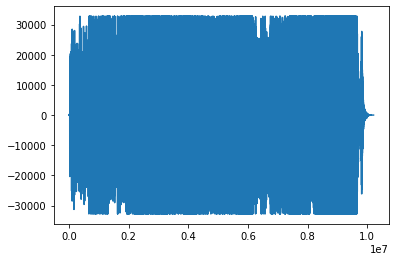

In [101]:
print(len(channels[0]))
print((len(arr2D)*len(arr2D[0])))
plt.plot(channels[0])

# 1 sec = 441
print(len(arr2D))
print(len(arr2D[0]))
print(len(channels[0])/len(arr2D[0])/44100)
print(myt[3]-myt[2])
print(myt[10]-myt[9])
